# Booking Demand Prediction

The goal is simple: Predict the booking demand for five 15-minute timesteps into the future.

In [1]:
# Uncomment and run to install the required libraries
# !pip3 install pygeohash simdkalman sklearn scipy==1.2 statsmodels pystan fbprophet tensorflow==2.0.0-alpha0 --upgrade

In [2]:
import math
import datetime
import multiprocessing

import numpy as np
import pandas as pd
import pygeohash as gh

import tensorflow.keras as tfk

import simdkalman
from sklearn.linear_model import HuberRegressor

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from fbprophet import Prophet

import matplotlib.pyplot as plt

## The data

### Load the raw data

In [3]:
# uncomment and run to download training.csv from the cloud
# !wget "https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip"
# !unzip "traffic-management.zip"
# !mv "Traffic Management/training.csv" "training.csv"
# !rm -r "Traffic Management" "traffic-management.zip"

In [4]:
# data_location = 'training.csv'
data_location = 'test.csv'    # <- for testing

In [5]:
df = pd.read_csv(data_location)
df.head()

,geohash6,day,timestamp,demand
0,qp03pn,10,14:30,0.024721
1,qp09sw,9,6:15,0.102821
2,qp03tu,1,12:15,0.023843
3,qp03r2,4,22:15,0.123463
4,qp03md,14,14:45,0.013998


### Feature Engineering

#### Add datetime features

In [6]:
timestamps = df['timestamp'].unique()
timestamps_decoded = {}
for timestamp in timestamps:
    timestamps_decoded[timestamp] = list(map(int, timestamp.split(':')))

In [7]:
%%time
df['hour']    = df['timestamp'].apply(lambda x : timestamps_decoded[x][0])
df['minutes'] = df['timestamp'].apply(lambda x : timestamps_decoded[x][1])

Wall time: 1.59 s


In [8]:
%%time
df['ds'] = df['day'].astype(str) + " " + df['timestamp']
df['ds'] = df['ds'].apply(lambda x : datetime.datetime.strptime(x, "%j %H:%M"))

Wall time: 28.1 s


In [9]:
df.head()

,geohash6,day,timestamp,demand,hour,minutes,ds
0,qp03pn,10,14:30,0.024721,14,30,1900-01-10 14:30:00
1,qp09sw,9,6:15,0.102821,6,15,1900-01-09 06:15:00
2,qp03tu,1,12:15,0.023843,12,15,1900-01-01 12:15:00
3,qp03r2,4,22:15,0.123463,22,15,1900-01-04 22:15:00
4,qp03md,14,14:45,0.013998,14,45,1900-01-14 14:45:00


#### Get unique locations

In [10]:
locations = df['geohash6'].unique()
print("The dataset has", len(locations), "unique geohashes:\n", locations)

The dataset has 1300 unique geohashes:
 ['qp03pn' 'qp09sw' 'qp03tu' ... 'qp09j9' 'qp0917' 'qp09dz']


#### Fill in the missing values

In [11]:
min_ds = df['ds'].min()
max_ds = df['ds'].max()
delta_ds = datetime.timedelta(minutes=15)
print(min_ds, '--to-->', max_ds, 'with steps:', delta_ds)

1900-01-01 00:00:00 --to--> 1900-01-14 23:45:00 with steps: 0:15:00


In [12]:
%%time
present_values = df[['geohash6', 'ds']].values
present_values = set(tuple(x) for x in present_values)

Wall time: 7.95 s


In [13]:
%%time
missing_values = []
for location in locations:
    cur_time = min_ds
    while cur_time <= max_ds:
        if not (location, cur_time) in present_values:
            x = {'geohash6' : location,
                 'day' : cur_time.dayofyear,
                 'timestamp' : str(int(cur_time.hour)) + ":" + str(int(cur_time.minute)),
                 'demand' : 0,
                 'hour' : cur_time.hour,
                 'minutes' : cur_time.minute,
                 'ds' : cur_time}
            missing_values.append(x)
        cur_time += delta_ds

Wall time: 26.1 s


In [14]:
%%time
df_missing = pd.DataFrame(missing_values)

Wall time: 2.93 s


In [15]:
df = pd.concat([df, df_missing], sort=False)
df = df.reset_index().drop('index', axis=1)
df.head()

,geohash6,day,timestamp,demand,hour,minutes,ds
0,qp03pn,10,14:30,0.024721,14,30,1900-01-10 14:30:00
1,qp09sw,9,6:15,0.102821,6,15,1900-01-09 06:15:00
2,qp03tu,1,12:15,0.023843,12,15,1900-01-01 12:15:00
3,qp03r2,4,22:15,0.123463,22,15,1900-01-04 22:15:00
4,qp03md,14,14:45,0.013998,14,45,1900-01-14 14:45:00


#### Decode the geohashes

In [16]:
locations_decoded = {}
for location in locations:
    locations_decoded[location] = gh.decode_exactly(location)

In [17]:
%%time
df['latitude']  = df['geohash6'].apply(lambda x : locations_decoded[x][0])
df['longitude'] = df['geohash6'].apply(lambda x : locations_decoded[x][1])

Wall time: 1.52 s


In [18]:
df.head()

,geohash6,day,timestamp,demand,hour,minutes,ds,latitude,longitude
0,qp03pn,10,14:30,0.024721,14,30,1900-01-10 14:30:00,-5.413513,90.664673
1,qp09sw,9,6:15,0.102821,6,15,1900-01-09 06:15:00,-5.325623,90.906372
2,qp03tu,1,12:15,0.023843,12,15,1900-01-01 12:15:00,-5.336609,90.609741
3,qp03r2,4,22:15,0.123463,22,15,1900-01-04 22:15:00,-5.402527,90.675659
4,qp03md,14,14:45,0.013998,14,45,1900-01-14 14:45:00,-5.391541,90.598755


#### Rename 'demand' to 'y' (for fbprophet)

In [19]:
df = df.rename(columns={'demand' : 'y'})
df.head()

,geohash6,day,timestamp,y,hour,minutes,ds,latitude,longitude
0,qp03pn,10,14:30,0.024721,14,30,1900-01-10 14:30:00,-5.413513,90.664673
1,qp09sw,9,6:15,0.102821,6,15,1900-01-09 06:15:00,-5.325623,90.906372
2,qp03tu,1,12:15,0.023843,12,15,1900-01-01 12:15:00,-5.336609,90.609741
3,qp03r2,4,22:15,0.123463,22,15,1900-01-04 22:15:00,-5.402527,90.675659
4,qp03md,14,14:45,0.013998,14,45,1900-01-14 14:45:00,-5.391541,90.598755


#### Sort by time

In [20]:
%%time
df = df.sort_values(by=['ds']).reset_index().drop('index', axis=1)

Wall time: 2.09 s


In [21]:
df.head()

,geohash6,day,timestamp,y,hour,minutes,ds,latitude,longitude
0,qp09d7,1,0:0,0.091915,0,0,1900-01-01,-5.342102,90.807495
1,qp0d5g,1,0:0,0.000000,0,0,1900-01-01,-5.254211,90.873413
2,qp03pw,1,0:0,0.016879,0,0,1900-01-01,-5.413513,90.686646
3,qp09jr,1,0:0,0.000000,0,0,1900-01-01,-5.408020,90.939331
4,qp02z1,1,0:0,0.000000,0,0,1900-01-01,-5.484924,90.664673


### Detect temporal anomalies

#### Get location infos

In [22]:
n_lat  = len(df['latitude'].unique())
n_long = len(df['longitude'].unique())
print(n_lat, n_long)

46 36


In [23]:
lat_min  = df['latitude'].min()
long_min = df['longitude'].min()
print(lat_min, long_min)

-5.48492431640625 90.5877685546875


In [24]:
lat_sorted  = np.sort(df['latitude'].unique())
long_sorted = np.sort(df['longitude'].unique())

In [25]:
lat_gap  = (lat_sorted[1:] - lat_sorted[:-1]).min()
long_gap = (long_sorted[1:] - long_sorted[:-1]).min()
print(lat_gap, long_gap)

0.0054931640625 0.010986328125


In [26]:
latitude_i  = ((df['latitude'].values  - lat_min)  / lat_gap).astype(int)
longitude_j = ((df['longitude'].values - long_min) / long_gap).astype(int)

#### Generate density images

In [27]:
timesteps = 4*24*(df['day'].values-1) + 4*df['hour'].values + df['minutes'].values//15
demands   = df['y'].values

In [28]:
%%time
density_images = np.zeros((4*24*61, 48, 40))
density_mask   = np.zeros((48, 40))
for i in range(len(timesteps)):
    t = timesteps[i]
    d = demands[i]
    x = latitude_i[i]
    y = longitude_j[i]
    density_images[t][x+1][y+2] = d
    density_mask[x+1][y+2] = 1

Wall time: 12.4 s


#### Inspect the images

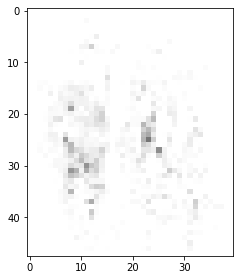

In [29]:
plt.imshow(density_images[0], vmin=0.0, vmax=1.0, cmap='binary')
plt.tight_layout()
plt.show()

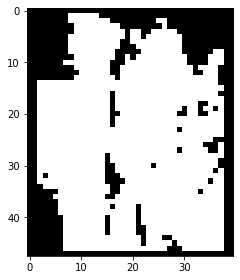

In [30]:
plt.imshow(1 - density_mask, vmin=0.0, vmax=1.0, cmap='binary')
plt.tight_layout()
plt.show()

#### Flatten images

In [31]:
flat_images = density_images.reshape(density_images.shape[0], -1).astype('float32')
flat_mask   = density_mask.reshape(-1).astype('float32')

#### Load the autoencoder

In [32]:
train_mu  = np.load('temporal_anomaly_detection/train_mu.npy')
train_std = np.load('temporal_anomaly_detection/train_std.npy')
print(train_mu, train_std)

[[ 0.02868951 -1.9072311 ]] [[0.5830229 2.27596  ]]


In [33]:
density_mask_sum = density_mask.sum()
    
def scaled_loss(inputs, outputs):
  outputs *= flat_mask
  loss = tfk.metrics.mean_squared_error(inputs, outputs)
  return density_mask_sum * loss

In [34]:
autoencoder = tfk.models.load_model('temporal_anomaly_detection/autoencoder.h5',
                                    custom_objects={'scaled_loss':scaled_loss})

#### Measure the mahalanobis distances of the encodings

In [35]:
latent_vars = autoencoder.get_layer('encoder')(flat_images).numpy()

In [36]:
mahalanobis_dist = (((latent_vars - train_mu)/train_std)**2).sum(axis=1)**(0.5)
mahalanobis_dist.shape

(5856,)

#### Find the anomalies

The data at time T is said to be anomalous if the mahalanobis distance (a multidimensional analogue of the standard deviation) of the latent encoding of the demand density map is greater than 4.

In [37]:
df['is_anomaly'] = np.array(list(map(lambda x : mahalanobis_dist[x] > 4.0, timesteps)))

In [38]:
df.head()

,geohash6,day,timestamp,y,hour,minutes,ds,latitude,longitude,is_anomaly
0,qp09d7,1,0:0,0.091915,0,0,1900-01-01,-5.342102,90.807495,False
1,qp0d5g,1,0:0,0.000000,0,0,1900-01-01,-5.254211,90.873413,False
2,qp03pw,1,0:0,0.016879,0,0,1900-01-01,-5.413513,90.686646,False
3,qp09jr,1,0:0,0.000000,0,0,1900-01-01,-5.408020,90.939331,False
4,qp02z1,1,0:0,0.000000,0,0,1900-01-01,-5.484924,90.664673,False


### Group the data by geohash

In [39]:
%%time

# df_cut = df[df['ds'] >= datetime.datetime.strptime(str(61-14), "%j")]
# df_cut = df_cut.reset_index().drop('index', axis=1)
# gb = df_cut.groupby('geohash6')

gb = df.groupby('geohash6')
location_series = {}
for x in gb.groups:
    group = gb.get_group(x).reset_index().drop('index', axis=1)
    location_series[x] = group

Wall time: 11 s


In [40]:
data_inputs = [(location, location_series[location]) for location in locations]

## The Model

In [41]:
future_ds = [max_ds + i*delta_ds for i in range(1, 5+1)]
future_ds

[Timestamp('1900-01-15 00:00:00'),
 Timestamp('1900-01-15 00:15:00'),
 Timestamp('1900-01-15 00:30:00'),
 Timestamp('1900-01-15 00:45:00'),
 Timestamp('1900-01-15 01:00:00')]

### Stage 1 (faster but less accurate)

Warning: had problems running the following blocks of code on windows. 

#### Run kalman filter and the theta forecasters in parallel

In [42]:
def stage1_worker(data_input):
    location, df_series = data_input
    
    # create train-test x values
    X_train = np.arange(len(df_series)).reshape(-1, 1)
    X_test  = (np.arange(5) + len(df_series)).reshape(-1, 1)
    
    # forecast using data from previous daily cycle
    # prev_pred = df_series['y'].values       <- deprecated
    
    # forecast using the kalman filter
    kf = simdkalman.KalmanFilter(
      state_transition = np.array([[1,1],[0,1]]),
      process_noise = np.diag([0.1, 0.01]),
      observation_model = np.array([[1,0]]),
      observation_noise = 0.5)
    kalman_pred = kf.predict(df_series['y'].values, 5).states.mean[:,0]
    
    # deseasonalize
    decomposition = sm.tsa.seasonal_decompose(df_series['y'] + 1e-9,
                                              model='multiplicative',
                                              freq=4*24,
                                              two_sided=False,
                                              extrapolate_trend=1)
    df_series['deseasonalized'] = df_series['y'].values / (decomposition.seasonal + 1e-9)
    seasonal_test = decomposition.seasonal.values[-4*24:-4*24+5]
    
    # forecast using theta = 0 (with linear regression)
    linreg = HuberRegressor().fit(X_train, df_series['deseasonalized'].values)
    theta0_pred = linreg.predict(X_test) * seasonal_test
    
    # forecast using theta = 2 (with simple exponential smoothing)
    y_theta2 = 2*df_series['deseasonalized'].values - linreg.predict(X_train)
    ses = SimpleExpSmoothing(y_theta2).fit()
    theta2_pred = ses.forecast(5) * seasonal_test
    
    # get the mean of the forecasts for theta = 0 and theta = 2
    theta_pred = (theta0_pred + theta2_pred) / 2.0
    
    # clip the predictions
    kalman_pred = np.clip(kalman_pred, a_min=0.0, a_max=1.0)
    theta_pred  = np.clip(theta_pred , a_min=0.0, a_max=1.0)
    
    # return_dict[location] = {'kalman_pred' : kalman_pred,
    #                          'theta_pred' : theta_pred}
    return location, kalman_pred, theta_pred

The following block takes around 30s on an 16-core machine. We can ignore the divide by zero warnings since they automatically get handled by statsmodels anyway.

In [ ]:
%%time

print("# of CPUs used:", multiprocessing.cpu_count())
p = multiprocessing.Pool(processes=multiprocessing.cpu_count())
stage1_results = p.map(stage1_worker, data_inputs)
p.close()

# of CPUs used: 4


#### Aggregate the results

In [ ]:
stage1_weights = [0.2969419 , 0.67783948]

In [ ]:
# %%time
stage1_dfprep = []
for result in stage1_results:
    location, kalman_pred, theta_pred = result
    stage1_pred = stage1_weights[0]*kalman_pred + stage1_weights[1]*theta_pred
    for i in range(5):
        x = {'geohash6' : location,
             'day' : future_ds[i].timetuple().tm_yday,
             'timestamp' : str(future_ds[i].hour) + ':' + str(future_ds[i].minute),
             'demand' : stage1_pred[i]}
        stage1_dfprep.append(x)

In [ ]:
df_stage1_results = pd.DataFrame(stage1_dfprep)
df_stage1_results.head()

#### Save the results

In [ ]:
df_stage1_results.to_csv("results_partial.csv", index=False)

### Stage 2 (more accurate but slower)

#### Run FBProphet in parallel

Make sure to run stage 1 first

In [85]:
def stage2_worker(data_input):
    location, df_series = data_input
    df_series['y'] += 1e-9
    
    prophet = Prophet(seasonality_mode='multiplicative',
                      weekly_seasonality=True,
                      yearly_seasonality=False)
    prophet.add_regressor('is_anomaly')
    prophet.fit(df_series)
    
    future = prophet.make_future_dataframe(periods=5, freq='15min', include_history=False)
    future['is_anomaly'] = 0
    prophet_pred = prophet.predict(future)['yhat'].values
    
    # clip
    prophet_pred  = np.clip(prophet_pred, a_min=0.0, a_max=1.0)
    
    return location, prophet_pred

Takes around 5 mins on a 16-core machine

In [86]:
%%time

p = multiprocessing.Pool(processes=multiprocessing.cpu_count())
stage2_results = p.map(stage2_worker, data_inputs)
p.close()

CPU times: user 1.71 s, sys: 1.47 s, total: 3.18 s
Wall time: 5min 7s


#### Aggregate the results

In [87]:
stage2_weights = [0.309658, 0.38132017, 0.29395973]

In [88]:
# %%time
stage2_preds = {}
stage2_dfprep = []
for result in stage1_results:
    location, kalman_pred, theta_pred = result
    stage2_preds[location] = stage2_weights[0]*kalman_pred + stage2_weights[1]*theta_pred
for result in stage2_results:
    location, prophet_pred = result
    stage2_preds[location] += stage2_weights[2]*prophet_pred
    for i in range(5):
        x = {'geohash6' : location,
             'day' : future_ds[i].timetuple().tm_yday,
             'timestamp' : str(future_ds[i].hour) + ':' + str(future_ds[i].minute),
             'demand' : stage2_preds[location][i]}
        stage2_dfprep.append(x)

In [89]:
df_stage2_results = pd.DataFrame(stage2_dfprep)
df_stage2_results.head()

,day,demand,geohash6,timestamp
0,62,0.084853,qp03wc,0:0
1,62,0.090412,qp03wc,0:15
2,62,0.094315,qp03wc,0:30
3,62,0.097274,qp03wc,0:45
4,62,0.103081,qp03wc,1:0


#### Save the results

In [90]:
df_stage2_results.to_csv("results_final.csv", index=False)